This example shows the simulation of a capacitor and an inductor.

To go further, you can read these pages on Wikipedia: [RC
circuit](https://en.wikipedia.org/wiki/RC_circuit) and [RL
circuit](https://en.wikipedia.org/wiki/RL_circuit).


In [1]:
import sys
sys.path.insert(0, '..')

from modules.simulator import Simulator
from modules.system import System, Wire
from modules.elements import *

import numpy as np
import matplotlib.pyplot as plt


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

from scipy.optimize import curve_fit


# Warning: the capacitor/inductor return current in the generator
#  could use switches instead



We will use a simple circuit where both capacitor and inductor are
driven by a pulse source through a limiting current resistor.


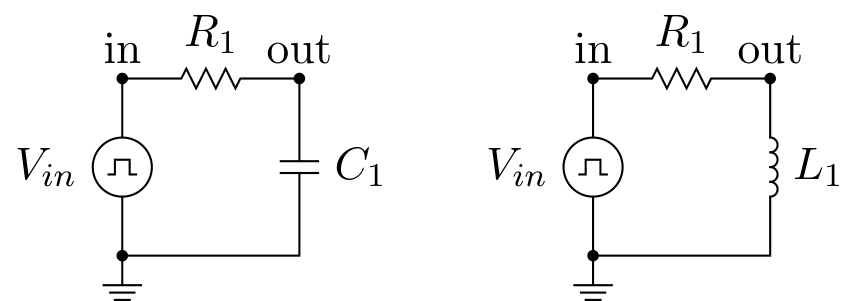

We will fit from the simulation output the time constant of each circuit
and compare it to the theoretical value.


tau capacitor = 0.001
tau inductor = 0.001


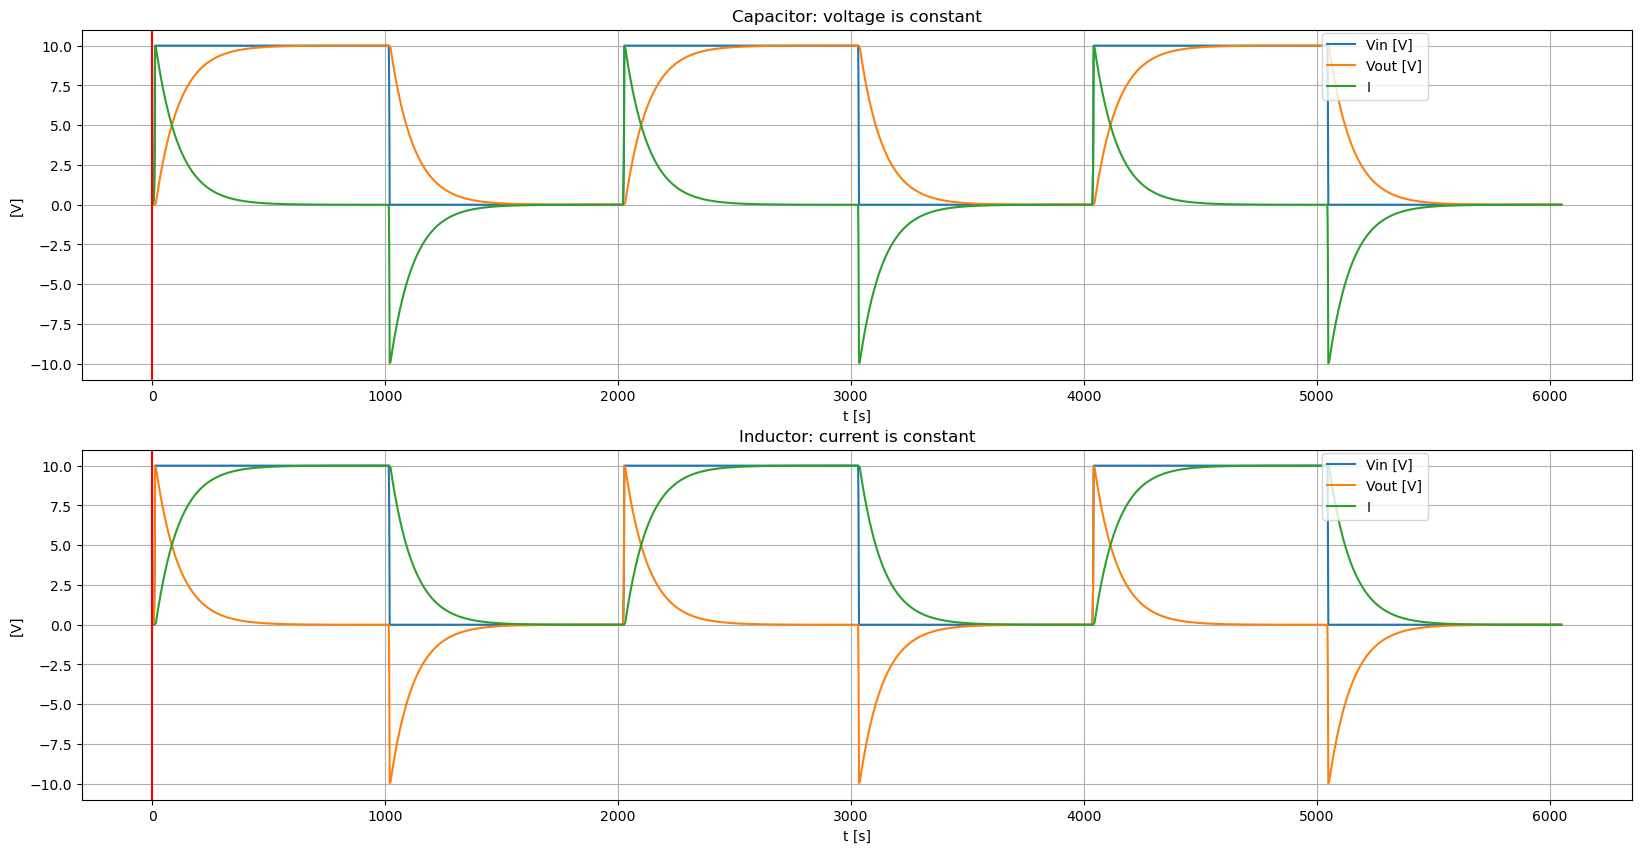

In [2]:
figure, (ax1, ax2) = plt.subplots(2, figsize=(20, 10))

element_types = ("capacitor", "inductor")

for element_type in ("capacitor", "inductor"):
    system = System()
    voltage = Voltage(system).Pulse(initial_value=0, pulsed_value=10, freq=1/(20e-3), duty=0.5)
    resistor = Resistor(system, 1e3)
    if element_type == "capacitor":
        element = Capacitor(system, 1e-6) # tau = RC = 1 ms
    else:
        element = Inductor(system, 1) # tau = L/R = 1 ms

    Wire(system, system.ground, element.n)
    Wire(system, element.p, resistor.n)
    Wire(system, resistor.p, voltage.p)
    Wire(system, voltage.n, system.ground)

    sim = Simulator(system)
    circuit = sim.system_to_pyspice(element_type)

    ckt_r = circuit[str(resistor)]
    if element_type == "capacitor":
        ckt_el = circuit[str(element)]
        tau = ckt_r.resistance * ckt_el.capacitance
    else:
        ckt_el = circuit[str(element)]
        tau = ckt_el.inductance / ckt_r.resistance

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    step_time = 10e-6
    analysis = simulator.transient(step_time=step_time, end_time=1/voltage.config.freq * 3)
    analysis_in = analysis[voltage.p.neighbor().deep_id()]
    analysis_out = analysis[element.p.neighbor().deep_id()]

    # Let define the theoretical output voltage.
    if element_type == "capacitor":
        def out_voltage(t, tau):
            return float(voltage.config.pulsed_value) * (1 - np.exp(-t / tau))
    else:
        def out_voltage(t, tau):
            return float(voltage.config.pulsed_value) * np.exp(-t / tau)

    print("tau {0} = {1}".format(element_type, tau))

    if element_type == "capacitor":
        ax = ax1
        title = "Capacitor: voltage is constant"
    else:
        ax = ax2
        title = "Inductor: current is constant"
    ax.set_title(title)
    ax.grid()
    current_scale = 1000
    ax.plot(analysis_in)
    ax.plot(analysis_out)
    ax.plot(
        ((analysis_in - analysis_out) / ckt_r.resistance) * current_scale
    )
    ax.axvline(x=float(tau), color="red")
    ax.set_ylim(-11, 11)
    ax.set_xlabel("t [s]")
    ax.set_ylabel("[V]")
    ax.legend(("Vin [V]", "Vout [V]", "I"), loc=(0.8, 0.8))